In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
import math

def plot_data_theory(datafile, x_col, y_col, theory_col='', title='', x_label='', y_label='', x_unit='', y_unit='', x_error=0.0, y_error=0.0, theory_error=0.0, no_reg = False, desc = '', ytype='linear', xtype='linear',
                     set_x=None, set_y=None, droite=False, axes0=(False,False),loglog = False,titrefig=None,maxindex=None,axe_round=1):
    """
    Permet de réaliser un graphique en utilisant des données expérimentales et théoriques, avec ou sans régression linéaire
    :param datafile: nom du fichier contenant les données à afficher (sans extension)
    :type datafile: str
    :param x_col: nom de la colonne contenant les valeurs en abscisse
    :type x_col: str
    :param y_col: nom de la colonne contenant les valeurs en ordonnée
    :type y_col: str
    :param theory_col: nom de la colonne contenant les valeurs théoriques en ordonnée (optionnel)
    :type theory_col: str
    :param title: titre du graphique (optionnel)
    :type title: str
    :param x_label: label de l'axe des abscisses (optionnel)
    :type x_label: str
    :param y_label: label de l'axe des ordonnées (optionnel)
    :type y_label: str
    :param x_unit: unité de l'axe des abscisses (optionnel)
    :type x_unit: str
    :param y_unit: unité de l'axe des ordonnées (optionnel)
    :type y_unit: str
    :param x_error: incertitude sur les valeurs en abscisse (optionnel)
    :type x_error: float
    :param y_error: incertitude sur les valeurs en ordonnée (optionnel)
    :type y_error: float
    :param theory_error: incertitude sur les valeurs théoriques en ordonnée (optionnel)
    :type theory_error: float
    :param no_reg: ne pas tracer la régression linéaire (optionnel)
    :type no_reg: bool
    :param desc: description de la série de données expérimentales (optionnel)
    :type desc: str
    :param ytype: type d'échelle pour l'axe des ordonnées (optionnel)
    :type ytype: str ('linear' ou 'log')
    :param xtype: type d'échelle pour l'axe des abscisses (optionnel)
    :type xtype: str ('linear' ou 'log')
    :param set_x: bornes pour l'axe des abscisses (optionnel)
    :type set_x: tuple (xmin, xmax)
    :param set_y: bornes pour l'axe des ordonnées (optionnel)
    :type set_y: tuple (ymin, ymax)
    :param droite: trace une droite au lieu de points pour les données expérimentales (optionnel)
    :type droite: bool
    :param axes0: afficher les axes x=0 et y=0 (optionnel)
    :type axes0: bool
    :param loglog: utilisation d'une échelle logarithmique pour les axes (optionnel)
    :type loglog: bool
    :return: None
    :rtype: None
    """

    df = pd.read_excel('data/'+datafile+'.xlsx')

    x = df[x_col]
    y = df[y_col]

    if maxindex:
        x = x[:maxindex]
        y = y[:maxindex]

    if loglog:
        x = np.log(x)
        y = np.log(y)

    # Create figure and axes
    fig, ax = plt.subplots()
    plt.yscale(ytype)
    plt.xscale(xtype)

    if theory_col != '':
        theory = df[theory_col]
        # Add theoretical data to the plot
        ax.plot(x, theory, '-', label='Théorique', lw=1, color='orange')
        if theory_error > 0:
            ax.errorbar(x, theory, yerr=theory_error, fmt='none', capsize=2, ecolor='orange')

    if not no_reg:
        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        a = slope
        b = intercept

        # Calcul de l'incertitude sur la pente
        delta_slope = get_delta_slope(x,y,x_error,y_error)
        ax.text(0.95, 0.15, f'a = {a:.4e} +- {delta_slope:1.0e}', transform=ax.transAxes, ha='right')
        ax.text(0.95, 0.10, f'b ~= {b:.4e}', transform=ax.transAxes, ha='right')

        # Add linear regression to the plot
        x_reg = np.linspace(x.min(), x.max(), 100)
        y_reg = slope * x_reg + intercept
        ax.plot(x_reg, y_reg, '--', label=f'Régression linéaire: f(x)=ax+b', lw=1, color='blue')

        # Add R^2 value to the plot
        ax.text(0.05, 0.95, f'$R^2 = {r_value**2:.2f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Add data points to the plot
    if droite:
        ax.plot(x, y, label=desc)
    elif loglog:
        plt.loglog(x, y)
    elif desc == '':
        ax.plot(x, y, 'o', label='Données expérimentales', ms=5, mec='blue', mew=1)
    else:
        ax.plot(x, y, 'o', label=desc, ms=5, mec='blue', mew=1)

    # Add axis labels and title
    ax.set_xlabel(x_label + ' (' + x_unit + ')')
    ax.set_ylabel(y_label + ' (' + y_unit + ')')
    ax.set_title(title)

    # Add legend
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # Add error bars
    if x_error > 0:
        ax.errorbar(x, y, xerr=x_error, fmt='none', capsize=3, ecolor='blue')
    if y_error > 0:
        ax.errorbar(x, y, yerr=y_error, fmt='none', capsize=3, ecolor='blue')

    # Add power of 10 scale to axes
    axis_round = '{x:.' + f'{axe_round}' + 'e}'
    ax.yaxis.set_major_formatter(axis_round)
    ax.xaxis.set_major_formatter(axis_round)

    #Define borns
    if set_x:
        plt.xlim(set_x[0], set_x[1])
    if set_y:
        plt.ylim(set_y[0], set_y[1])


    # Afficher les axes x=0 et y=0
    if axes0[0] == True:
        ax.axhline(y=0, color='black')
    if axes0[1] == True:
        ax.axvline(x=0, color='black')

    plt.savefig(f"fig/{titrefig}",bbox_inches='tight',dpi=300)

    plt.show()

def get_delta_slope(x,y,x_err,y_err):
    n = np.size(x)-1
    x1max = x[0] + x_err
    y1max = y[0] - y_err
    x2max = x[n] - x_err
    y2max = y[n] + y_err

    slopemax = (y2max-y1max)/(x2max-x1max)

    x1min = x[0] - x_err
    y1min = y[0] + y_err
    x2min = x[n] + x_err
    y2min = y[n] - y_err

    slopemin = (y2min-y1min)/(x2min-x1min)

    final = abs(slopemax-slopemin)
    final /= 2
    return final

def get_incertitude(tab_val,cst):
    """
    Permet de récupérer les valeurs d'incertitudes d'une équation prenant plusieurs variables.
    :param cst: Constante à laquelle multiplier le final
    :param tab_val: [(valeur,incertitude_absolue,puissance),...]
    :return: tuple (valeur_finale,incertitude_finale)
    """
    valeur_finale = cst
    incertitude_finale = 0

    for val,inc_abs,puiss in tab_val:
        valeur_finale *= val**puiss
        incertitude_finale += (puiss*inc_abs/val)**2
    incertitude_finale = valeur_finale * np.sqrt(incertitude_finale)

    return valeur_finale,incertitude_finale

def get_resistivity_from_length(slope, delta_slope, diameter, delta_diameter):
    #Permet d'obtenir la resistivité
    return get_incertitude([(slope,delta_slope,1),(diameter,delta_diameter,2)],math.pi/4)

def get_resistivity_from_diameter(slope, delta_slope, length,delta_length):
    #Permet d'obtenir la resistivité
    return get_incertitude([(slope,delta_slope,1),(length,delta_length,-1)],math.pi/4)

In [18]:
#Test pour une valeur connue
get_incertitude([(1.52,0.02,2),(156,5,-1)],1)

(0.01481025641025641, 0.000614189289599054)

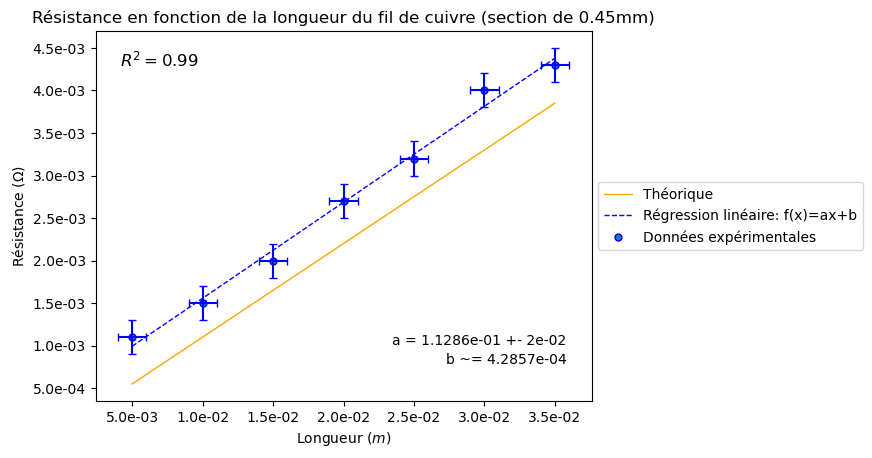

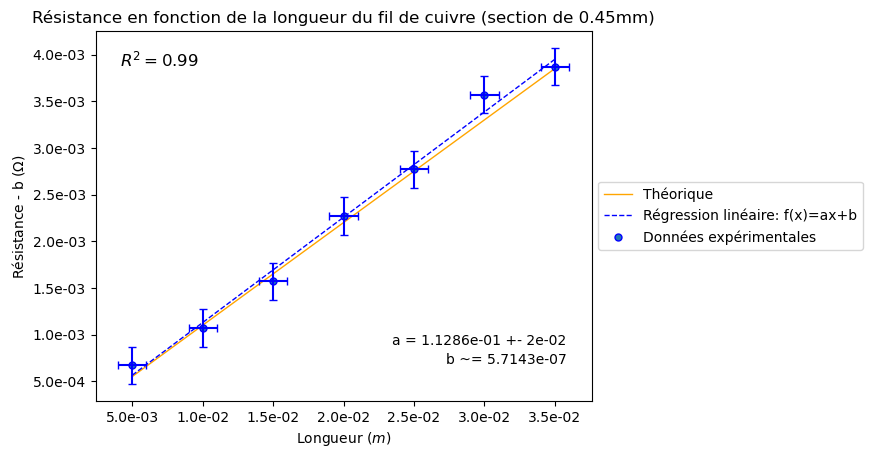

(1.749474408967816e-08, 3.274517001238273e-09)


In [19]:
# appel de la fonction pour tracer le graphique pour 0.45 mm de section de cuivre
plot_data_theory('data045', 'Longueur', 'Resistance', 'Theorique',
                  title='Résistance en fonction de la longueur du fil de cuivre (section de 0.45mm)',
                  x_label='Longueur', y_label='Résistance',x_unit='$m$',y_unit=r'$\Omega$',x_error=0.001,y_error=0.0002,titrefig="cuivre_resist_long")

#Si on retire b
plot_data_theory('data045', 'Longueur', 'Resistance-', 'Theorique',
                  title='Résistance en fonction de la longueur du fil de cuivre (section de 0.45mm)',
                  x_label='Longueur', y_label='Résistance - b',x_unit='$m$',y_unit=r'$\Omega$',x_error=0.001,y_error=0.0002,titrefig="cuivre_resist-_long")

print(get_resistivity_from_length(0.11,0.02,0.00045,0.00001))

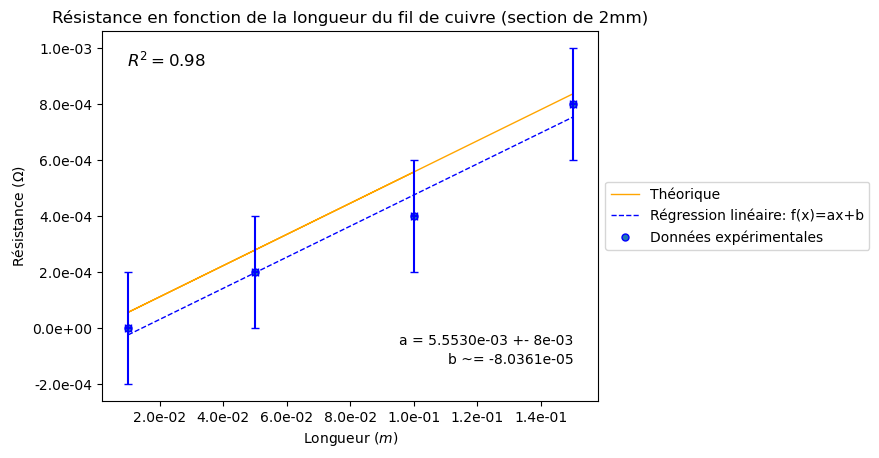

(1.5707963267948965e-08, 2.5133232097776873e-08)


In [20]:
# appel de la fonction pour tracer le graphique pour 2 mm de section de cuivre
plot_data_theory('data2', 'Longueur', 'Resistance', 'Theorique',
                  title='Résistance en fonction de la longueur du fil de cuivre (section de 2mm)',
                  x_label='Longueur', y_label='Résistance',x_unit='$m$',y_unit=r'$\Omega$',x_error=0.001,y_error=0.0002,titrefig="cuivre2_resist_long")
print(get_resistivity_from_length(0.005,0.008,0.002,0.00001))

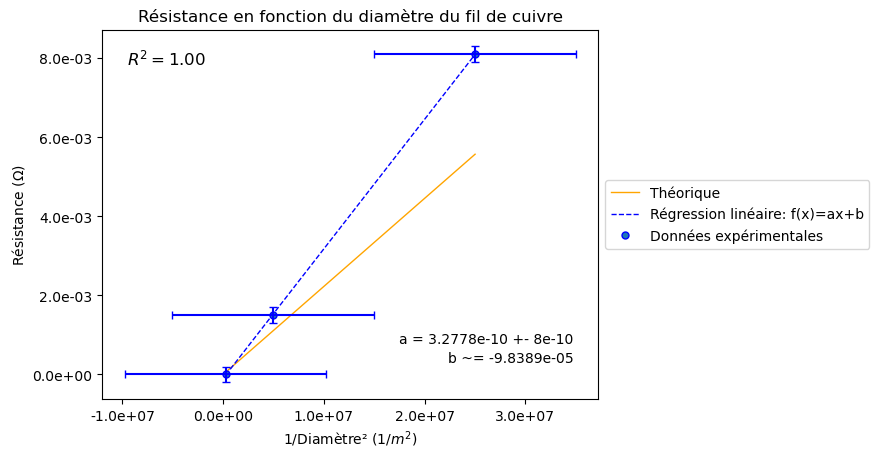

(2.3561944901923447e-08, 6.358238357630173e-08)


In [21]:
# appel de la fonction pour tracer le graphique pour le diamètre avec un fil de 1mm de long
plot_data_theory('data_diam', 'Diametre^-2', 'Resistance', 'Theorique',
                  title='Résistance en fonction du diamètre du fil de cuivre',
                  x_label='1/Diamètre²', y_label='Résistance',x_unit=r'$1/m^2$',y_unit=r'$\Omega$',x_error=10000000,y_error=0.0002,titrefig="cuivre_resist_diam2")
print(get_resistivity_from_diameter(0.0000000003,0.000000000809,0.01,0.001))

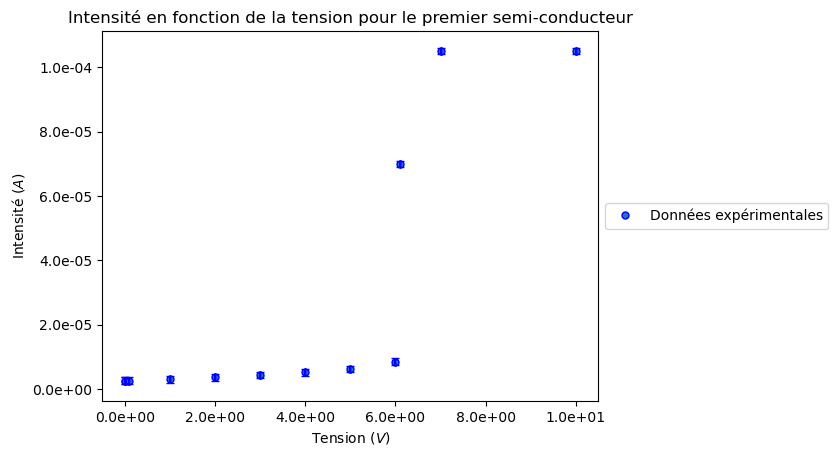

In [22]:
# appel de la fonction pour tracer le graphique pour intensité en fonction de la tension pour le premier semi
plot_data_theory('data_semi', 'Tension', 'Intensité',
                  title='Intensité en fonction de la tension pour le premier semi-conducteur',
                  x_label='Tension', y_label='Intensité',x_unit='$V$',y_unit='$A$',x_error=0.0005,y_error=0.000001,no_reg = True,titrefig="semi1_int_tension")

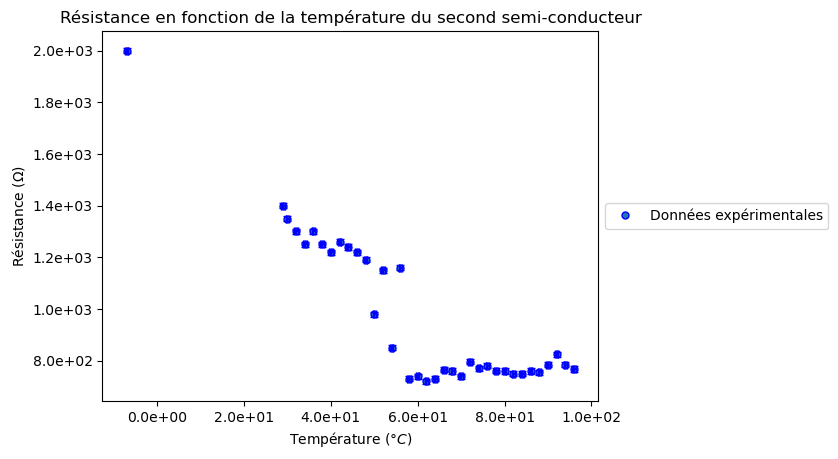

In [23]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour le deuxième semi
plot_data_theory('data_temp_semi2', 'Temp', 'Ohms',
                 title='Résistance en fonction de la température du second semi-conducteur',
                 x_label='Température', y_label='Résistance', x_unit='$°C$', y_unit=r'$\Omega$', x_error=0.4,
                 y_error=10, no_reg=True,titrefig="semi2_resist_temp")

ValueError: too many values to unpack (expected 1)

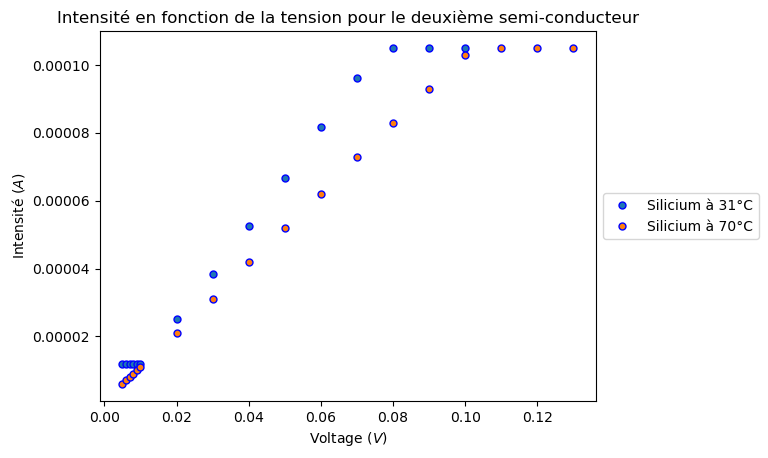

In [24]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour le deuxième semi
plot_data_theory('data_difftemp_vi', ['V31','V70'], ['I31','I70'],
                 desc = ['Silicium à 31°C','Silicium à 70°C'],
                 title='Intensité en fonction de la tension pour le deuxième semi-conducteur',
                 x_label='Voltage', y_label='Intensité', x_unit='$V$', y_unit='$A$', x_error=0.0001,
                 y_error=0.000001, no_reg=True,titrefig="semi2_int_volt")

In [26]:
# On calcule l'incertitude de la resistivité avec la formule p = R*pi*D²/(4l)
# On choisit ici l'incertitude globale sur la résistance et une valeur moyenne

get_incertitude([(0.011,0.0001,1),(0.0005,0.00001,2),(0.1,0.01,-1)],math.pi/4)

(2.1598449493429822e-08, 2.334496129837556e-09)

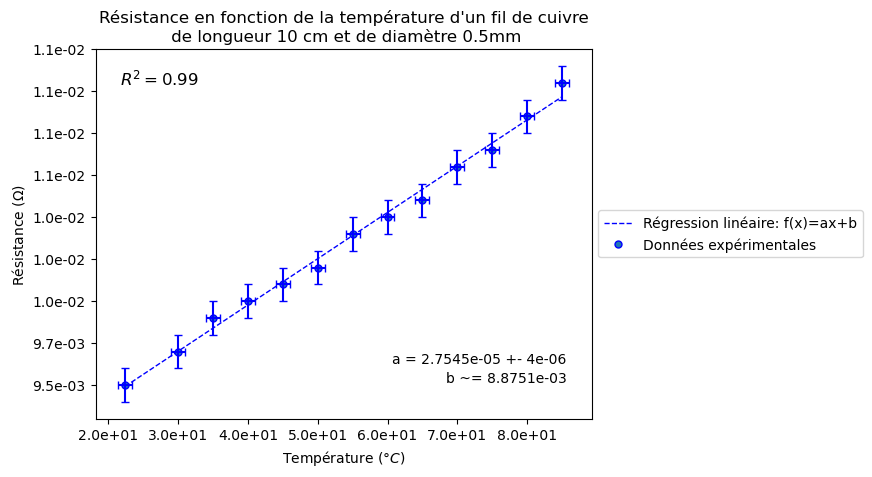

Incertitude de R/R0 : 
0.01414213562373095
Incertitude de T-TO : 2


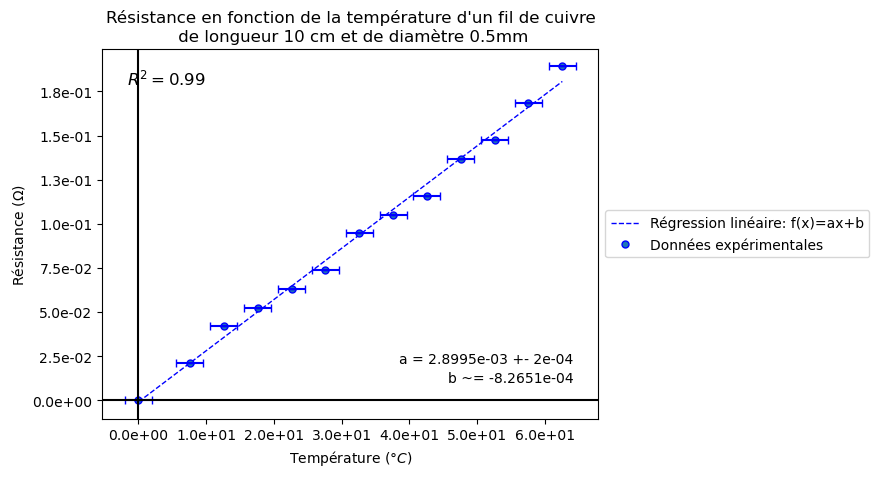

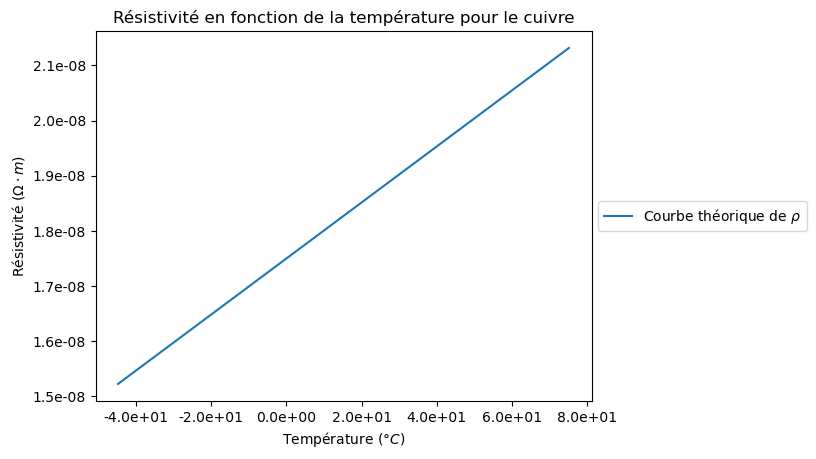

In [27]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour un fil de taille
plot_data_theory('data_cuivre_temp', 'Température', 'Résistance',
                 title="Résistance en fonction de la température d'un fil de cuivre\n de longueur 10 cm et de diamètre 0.5mm",
                 x_label='Température', y_label='Résistance', x_unit='$°C$', y_unit=r'$\Omega$', x_error=1,
                 y_error=0.0001,titrefig="cuivre_resi_temp")
#b non nul, on divise alors par RO la température la plus faible à 22,4°C et pour la température on exprime DeltaT
a,b = get_incertitude([(0.01,0.0001,1),(0.01,0.0001,-1)],1)
print("Incertitude de R/R0 : ")
print(b)
print("Incertitude de T-TO : 2")
plot_data_theory('data_cuivre_temp', 'DeltaTemp', 'Resistance-',
                 title="Résistance en fonction de la température d'un fil de cuivre\n de longueur 10 cm et de diamètre 0.5mm",
                 x_label='Température', y_label='Résistance', x_unit='$°C$', y_unit=r'$\Omega$', x_error=2,
                 y_error=0.000001,axes0=True,titrefig="cuivre_resi-_dtemp")

plot_data_theory('data_cuivre_temp', 'AllDeltaTemp', 'AllResistivite',
                 title="Résistivité en fonction de la température pour le cuivre",
                 x_label='Température', y_label=r'Résistivité', x_unit='$°C$', y_unit=r'$\Omega\cdot m$',no_reg=True,desc=r"Courbe théorique de $\rho$",droite=True,titrefig="cuivre_theo_resi_temp") #On entre ici l'incertitude trouvée plus haut

In [28]:
from sklearn.linear_model import LinearRegression

def plot_regression(filename, col1, col2, n, temp_piece, no,set_x=None, set_y=None):
    """
    Trace un graphique de régression linéaire à partir d'un fichier Excel contenant des données expérimentales.

    Parameters
    ----------
    filename : str
        Le nom du fichier Excel à charger, situé dans le dossier 'data'.
    col1 : str
        Le nom de la première colonne de données à utiliser pour la régression linéaire.
    col2 : str
        Le nom de la deuxième colonne de données à utiliser pour la régression linéaire.
    n : int
        Le nombre de premières valeurs à utiliser pour la régression linéaire.
    temp_piece : float
        La température de la pièce à utiliser pour tracer la courbe théorique.
    set_x : Optional[Tuple[float, float]], default=None
        Les bornes de la plage de valeurs à afficher sur l'axe x.
    set_y : Optional[Tuple[float, float]], default=None
        Les bornes de la plage de valeurs à afficher sur l'axe y.

    Returns
    -------
    None

    Raises
    ------
    FileNotFoundError
        Si le fichier Excel n'existe pas dans le dossier 'data'.

    Examples
    --------
    >>> plot_regression('data.xlsx', 'colonne1', 'colonne2', 50, 20, set_x=(0, 100), set_y=(0, 200))
    """

    # Load the Excel file
    df = pd.read_excel('data/' + filename)

    # Select the two columns of interest
    x = df[col1]
    y = df[col2]

    # Create figure and axes
    fig, ax = plt.subplots()

    # Plot the data
    plt.scatter(x, y, label="Données Experimentale")

    # Perform linear regression on the first n points
    X = np.array(x[:n]).reshape(-1, 1)
    y = np.array(y[:n]).reshape(-1, 1)
    model = LinearRegression().fit(X, y)

    # Extract the slope and intercept
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    print("Pente (a) : " , slope , "\nHauteur (b) : " , intercept)

    # Add linear regression to the plot
    x_reg = np.linspace(x.min(), x.max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, '--', label=f'Régression linéaire: f(x)=ax+b', lw=1, color='cyan')

    # Add R^2 value to the plot
    r_squared = model.score(X, y)
    ax.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Add titles and labels
    plt.title('Regression linéaire sur les {} premières valeurs de {}'.format(n, col2))
    plt.xlabel(col1)
    plt.ylabel(col2)

    # Add power of 10 scale to axes
    ax.yaxis.set_major_formatter('{x:.1e}')
    ax.xaxis.set_major_formatter('{x:.1e}')

    #Define borns
    if set_x:
        plt.xlim(set_x[0], set_x[1])
    if set_y:
        plt.ylim(set_y[0], set_y[1])

    # Find the x value corresponding to y = temp_piece
    tau = (temp_piece - intercept) / slope
    print(f"tau={tau:.2f} secondes")

    #Add theorical plot
    y_theo = temp_piece + (y_reg[0] - temp_piece)*np.exp(-x/tau)
    ax.plot(x,y_theo , '-', label=f'Courbe théorique obtenue', lw=1, color='orange')


    # Show the plot
    # Add legend
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig(f"fig/test_temp_temps{no}")
    plt.show()

Pente (a) :  0.08202020202020205 
Hauteur (b) :  -5.867272727272727
tau=315.38 secondes


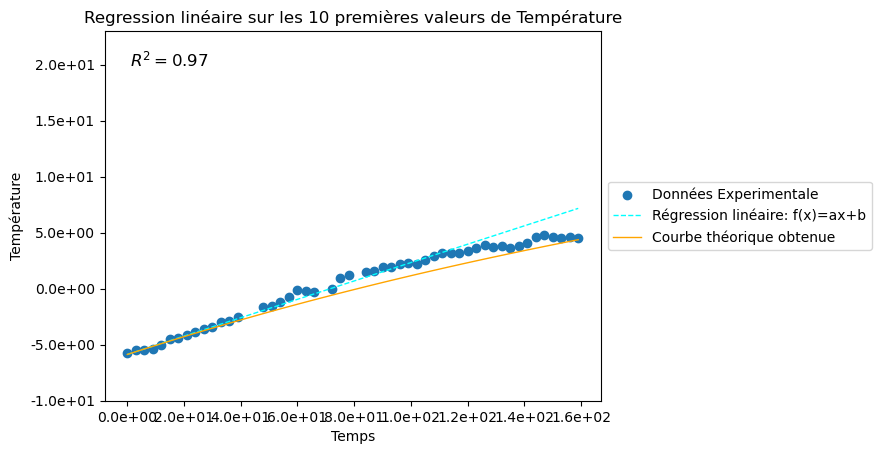

Pente (a) :  0.03436611374407582 
Hauteur (b) :  2.708175355450237
tau=503.16 secondes


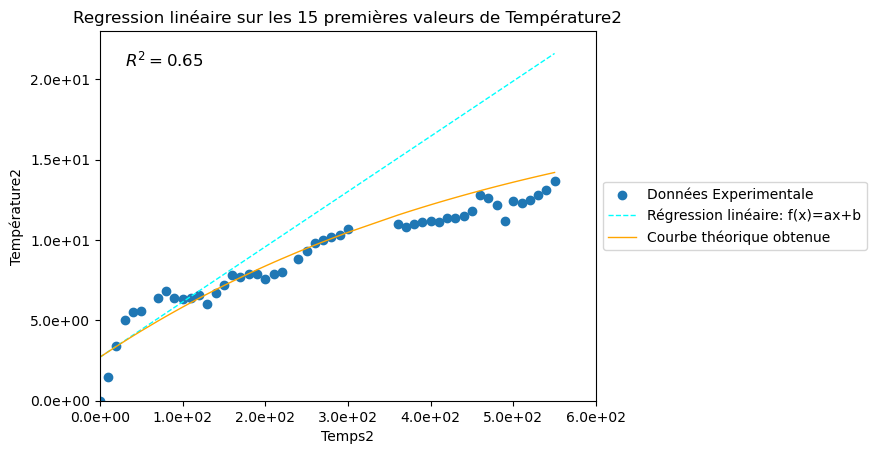

Pente (a) :  0.06523809523809523 
Hauteur (b) :  4.691666666666667
tau=234.65 secondes


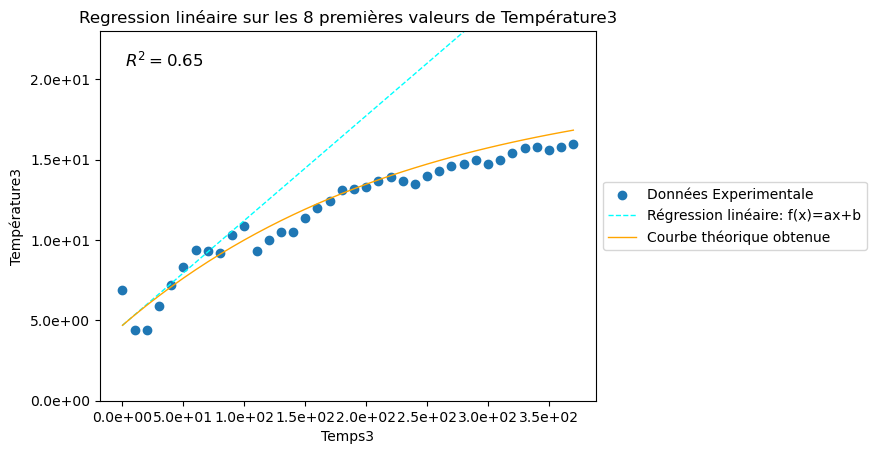

Pente (a) :  0.20845238095238097 
Hauteur (b) :  -9.033335417857144
tau=139.28 secondes


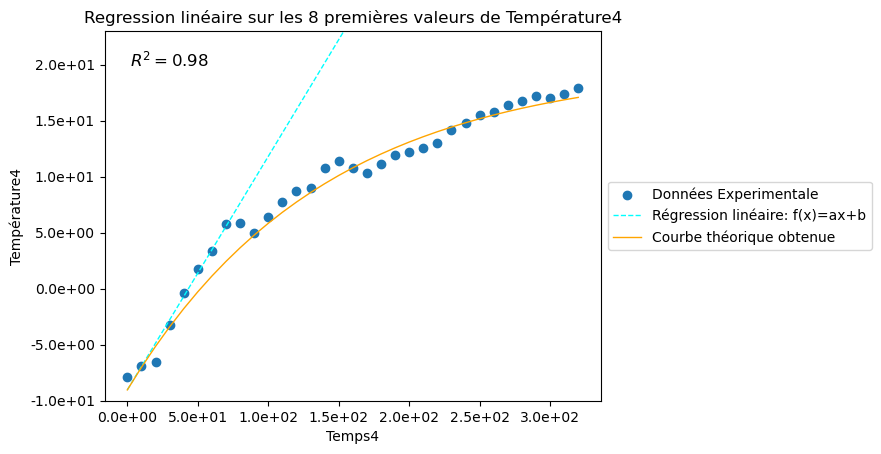

In [29]:
plot_regression('tempeallen.xlsx', 'Temps', 'Température',10,20,1,set_y=[-10,23])
plot_regression('tempeallen.xlsx', 'Temps2', 'Température2',15,20,2,set_x=[0,600],set_y=[0,23])
plot_regression('tempeallen.xlsx', 'Temps3', 'Température3',8,20,3,set_y=[0,23])
plot_regression('tempeallen.xlsx', 'Temps4', 'Température4',8,20,4,set_y=[-10,23])

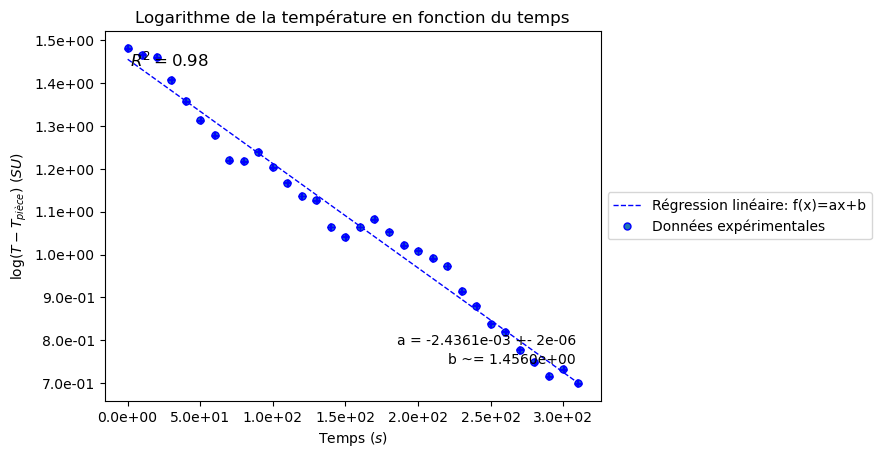

In [30]:
# appel de la fonction pour tracer le graphique de la résistance en fonction de la température pour un fil de taille
plot_data_theory('tempeallen', 'Temps4', 'logTempé',
                 title="Logarithme de la température en fonction du temps",
                 x_label='Temps', y_label=r'$\log(T-T_{pièce})$', x_unit='$s$', y_unit=r'$SU$',titrefig="log_supra_temp",x_error=0.3,y_error=0.001,maxindex=32)

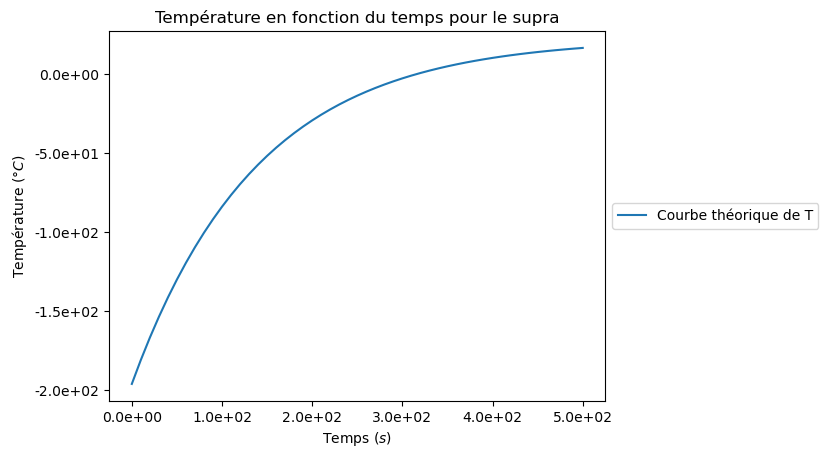

In [39]:
def get_temp_from_time(time):
    return 22.4 + (-196 - 22.4 )*np.exp(-time/139)

plot_data_theory('tempeallen', 'AllTemps', 'AllTempé',
                 title="Température en fonction du temps pour le supraconducteur",
                 x_label='Temps', y_label=r'Température', x_unit='$s$', y_unit=r'$°C$',no_reg=True,desc=r"Courbe théorique de T",droite=True,titrefig="supra_tempé_temps_theo") #On entre ici l'incertitude trouvée plus haut

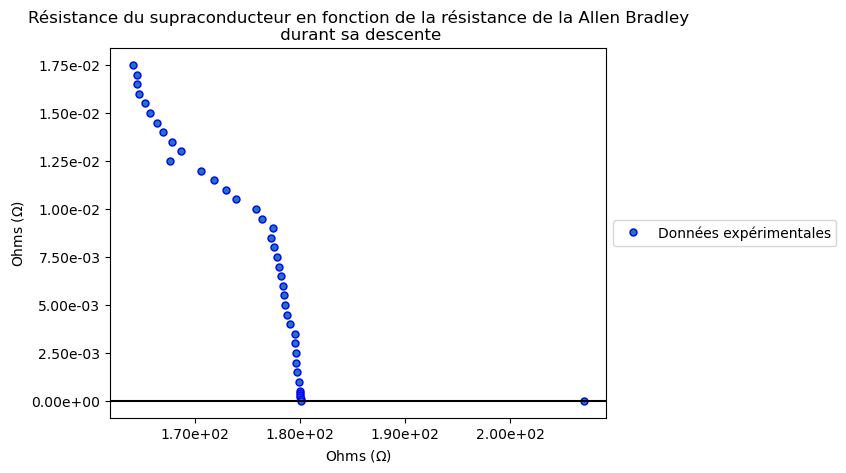

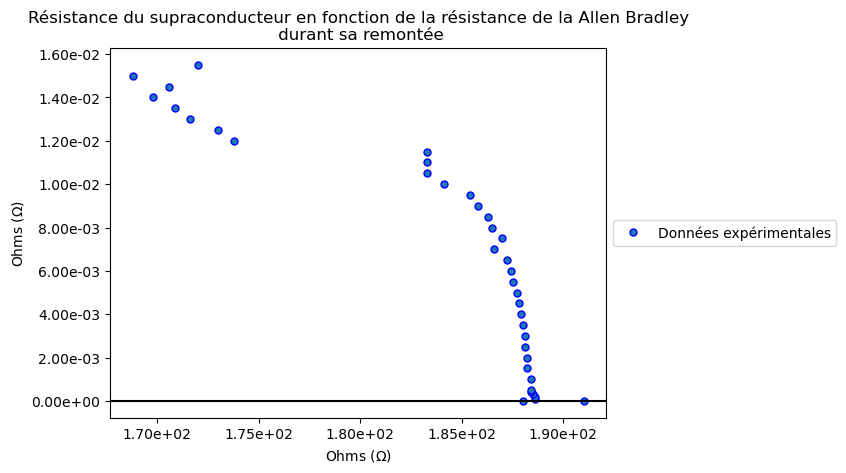

In [57]:
plot_data_theory('Supra', 'D allen2', 'D supra2',
                 title="Résistance du supraconducteur en fonction de la résistance de la Allen Bradley\n durant sa descente",
                 x_label=r'Ohms', y_label=r'Ohms', x_unit='$\Omega$', y_unit=r'$\Omega$',no_reg=True,titrefig="supra_allen_descente",axes0=(True,False),axe_round=2)
plot_data_theory('Supra', 'M allen', 'M supra',
                 title="Résistance du supraconducteur en fonction de la résistance de la Allen Bradley\n durant sa remontée",
                 x_label=r'Ohms', y_label=r'Ohms', x_unit='$\Omega$', y_unit=r'$\Omega$',no_reg=True,titrefig="supra_allen_montee",axes0=(True,False),axe_round=2)